# Get ingo about GPU

In [1]:
!pip install gputil
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import GPUtil

gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f'GPU ID: {gpu.id} | GPU Model: {gpu.name}')
    print(f'Total Memory: {gpu.memoryTotal} MB | Free Memory: {gpu.memoryFree} MB | Used Memory: {gpu.memoryUsed} MB')
    print('-----')

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=a5309b8a2916897c93891992ab71414edf6b880bb04b0e87498f5bbf12aff738
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Tue May 14 05:13:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Import usefull packages

In [3]:
# pustit (eng a deu), doladit
# prednacitani
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!pip3 install pytorch_lightning
# mozna prepsat do condy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 52.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [4]:
# standart Python libraries
import gc
import sys
import time
import math
import copy
import itertools
import shutil
from random import shuffle
import random

# other libraries
import numpy as np
import matplotlib.pyplot as plt
import torchaudio

# functions of Google Colab
from google.colab import files, drive

# functions of PyTorch
import torch
from torch import nn, optim
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.profilers import SimpleProfiler, AdvancedProfiler
import torch.nn.functional as F
from torch.functional import Tensor
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

# Additional commands for work with Tensorboard and Jupyter
%load_ext tensorboard

In [5]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 52.4 GB  |     Proc size: 1.1 GB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total     15360MB


In [6]:
# Check an accessibility of the GPU and set device

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


# Access to kaggle & Loading of Datasets

## Clone dataset from Google Drive

In [8]:
def clone_to_colab(sets: list[str]):
    if 'en' in sets:
        !cp -r /content/drive/MyDrive/artificial/datasets/dev_en.zip /content
        !unzip dev_en.zip
        # !tar -xvf train_en.tgz
        # !rm traindev_en.zip

    if 'ge' in sets:
        !cp -r /content/drive/MyDrive/artificial/datasets/train_dev/dataset.zip /content
        !unzip /content/dataset.zip
        !rm /content/dataset.zip

    if 'tests' in sets:
        !cp -r /content/drive/MyDrive/artificial/datasets/test/en_test.zip /content
        !unzip /content/en_test.zip
        !rm /content/en_test.zip

        !cp -r /content/drive/MyDrive/artificial/datasets/test/ge_test.zip /content
        !unzip /content/ge_test.zip
        !rm /content/ge_test.zip

        !cp -r /content/drive/MyDrive/artificial/datasets/test/korean_test.zip /content
        !unzip /content/korean_test.zip
        !rm /content/korean_test.zip
    if 'reverbs' in sets:
        !cp -r /content/drive/MyDrive/artificial/datasets/reverbs_set.zip /content
        !unzip /content/reverbs_set.zip
        !rm /content/reverbs_set.zip
    if 'new' in sets:
        !cp -r /content/drive/MyDrive/artificial/datasets/reverberations.zip /content
        !unzip /content/reverberations.zip
        !rm /content/reverberations.zip

        # !cp -r /content/drive/MyDrive/artificial/datasets/comb.zip /content
        # !unzip /content/comb.zip
        # !rm /content/comb.zip
    if 'example_data' in sets:
        !cp -r /content/drive/MyDrive/artificial/datasets/example_dataset.zip /content
        !unzip /content/example_dataset.zip
        !rm /content/example_dataset.zip


clone_to_colab(['example_data'])

Archive:  /content/example_dataset.zip
   creating: example_dataset/
 extracting: example_dataset/exampleSNR.txt  
 extracting: example_dataset/exampleSoundsRoad.txt  
 extracting: example_dataset/exampleSTOI.txt  
 extracting: example_dataset/exampleT60.txt  
   creating: example_dataset/test_0/
   creating: example_dataset/test_0/x/
 extracting: example_dataset/test_0/x/0_angle-15_t240_8747-293952-0011.flac  
 extracting: example_dataset/test_0/x/0_angle-15_t320_8975-270782-0029.flac  
 extracting: example_dataset/test_0/x/0_angle-15_t640_911-128684-0062.flac  
 extracting: example_dataset/test_0/x/0_angle-30_t400_8580-287363-0033.flac  
 extracting: example_dataset/test_0/x/0_angle-30_t720_8629-261140-0012.flac  
 extracting: example_dataset/test_0/x/0_angle-30_t800_887-123289-0009.flac  
 extracting: example_dataset/test_0/x/0_angle-45_t160_87-121553-0033.flac  
 extracting: example_dataset/test_0/x/0_angle-45_t480_8770-295465-0003.flac  
 extracting: example_dataset/test_0/x/0_ang

## Clone dataset from Kaggel
To access a private dataset on Kaggle, the kaggle.json file is required.

In [ ]:
# load kaggle access file
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!chmod 600 /content/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
start_time = time.time()

# load paths and referencies
# URL to Kaggle dataset: https://www.kaggle.com/datasets/mothspaws/noisy-en-dataset
!kaggle datasets download "mothspaws/noisy-en-dataset"
!unzip "noisy-en-dataset.zip"
!rm "noisy-en-dataset.zip"
print("--- %s seconds ---" % (time.time() - start_time))

# Stable 1 sec
preload only one second from the whole dataset. It was used for testing, if our model architecture could memorise 1 second of signal

In [ ]:
BATCH_SIZE_set = 100

class UploadArtificialDataModule(pl.LightningDataModule):

    def __init__(self, file_with_paths_train, links_SNR_refs_train, links_STOI_refs_train, audio_place_train,
                 file_with_paths_val, links_SNR_refs_val, links_STOI_refs_val, audio_place_val,
                file_with_paths_test, links_SNR_refs_test, links_STOI_refs_test, audio_place_test,
                 transformation, device, **kwargs):
        super().__init__()
        self.file_with_paths_train = file_with_paths_train
        self.links_SNR_refs_train = links_SNR_refs_train
        self.links_STOI_refs_train = links_STOI_refs_train
        self.audio_place_train = audio_place_train

        self.file_with_paths_val = file_with_paths_val
        self.links_SNR_refs_val = links_SNR_refs_val
        self.links_STOI_refs_val = links_STOI_refs_val
        self.audio_place_val = audio_place_val

        self.file_with_paths_test = file_with_paths_test
        self.links_SNR_refs_test = links_SNR_refs_test
        self.links_STOI_refs_test = links_STOI_refs_test
        self.audio_place_test = audio_place_test

        self.transformation = transformation
        self.device = device
        self.kwargs = kwargs
        self.data_loader = 0
        self.load_validation = True

    def setup(self, stage=None):
        selected_indices = [1,2,3,26000, 26001, 26002, 53000, 80000, 105000]
        self.train_dataset = UploadArtificialDataset(self.file_with_paths_train,
                                     self.links_SNR_refs_train,
                                     self.links_STOI_refs_train,
                                     self.transformation,
                                     self.device,
                                     self.audio_place_train,
                                     selected_indices=selected_indices, **self.kwargs)

    def _count_lines(self, file_path):
        with open(file_path, "r") as f:
            return len([line.strip() for line in f.readlines()])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE_set, shuffle=True, drop_last=True)

    def val_dataloader(self):
        # return DataLoader(self.val_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)

        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True)

    def generate_index_lists(self):
        index_array = np.arange(self._count_lines(self.file_with_paths_train))
        parts = np.array_split(index_array, 6)

        for part in parts:
            shuffle(part)

        # subparts = [np.array_split(part[:-1], 5) for part in parts]
        subparts = [np.array_split(part[:-4], 5) for part in parts]

        # Create 5 index lists, each containing 20% from each of the 6 parts
        index_lists = [[subpart[i] for subpart in subparts] for i in range(5)]
        # Concatenate subparts for each index list and convert them to lists
        index_lists = [np.concatenate(index_list).tolist() for index_list in index_lists]

        # Shuffle each list
        for index_list in index_lists:
            shuffle(index_list)

        return index_lists


def normalize(data):
    mean, std = torch.mean(data), torch.std(data)
    return (data - mean) / std


class UploadArtificialDataset(Dataset):
    def __init__(self, file_with_paths, links_SNR_refs, links_STOI_refs,
                 transformation, device, audio_place, selected_indices,
                 old_min=-50, old_max=50, new_min=0, new_max=1,
                 nMels=64, hopLength=256, sample_rate=16000, **kwargs):
        self.paths = np.array(self._loader(file_with_paths))
        self.SNR_ref = np.array(self._loader(links_SNR_refs))
        self.STOI_ref = np.array(self._loader(links_STOI_refs))
        self.device = device
        self.transformation = transformation.to(self.device)
        self.audio_place = audio_place
        self.old_min = old_min
        self.old_max = old_max
        self.new_min = new_min
        self.new_max = new_max
        self.nMels = nMels
        self.hopLength = hopLength
        self.sample_rate = sample_rate

        # Store the selected indices
        self.selected_indices = selected_indices

        self.possibilities = set()
        self.generate_set_of_possibilities()
        self.preloaded_dataset, self.preloaded_snrs, self.preloaded_stois = 0,0,0
        self.preload()
        print("Loading finished self len:", len(self))

    def _loader(self, path):
        with open(path, "r") as f:
            return [line.strip() for line in f.readlines()]

    def _preprocess_snr_values(self, snr_string):
        snr_values = torch.tensor([float(x) for x in snr_string.split('|')], device=self.device)
        snr_values[snr_values < -50] = -50
        if old_max == old_min or new_max == new_min:
            raise ValueError("Invalid range: old and new ranges must have different min and max values.")

        # Calculate the scale factors
        old_range = old_max - old_min
        new_range = new_max - new_min

        return ((snr_values - old_min) / old_range) * new_range + new_min

    def preload(self):
        line_ind = 141281
        second_ind = 3

        total_samples = len(self)
        dataset_seconds = torch.zeros(total_samples, self.nMels, int(self.sample_rate / self.hopLength), device=self.device)
        snrs = torch.zeros(total_samples, device=self.device)
        stois = torch.zeros(total_samples, device=self.device)

        signal, _ = torchaudio.load(f"{self.audio_place}{self.paths[line_ind]}")
        print("Road to data:", self.paths[line_ind])
        signal = normalize(signal).to(self.device)
        signal = self.transformation(signal) + 1e-4
        signal = 10 * torch.log10(signal)
        segments = signal.unfold(dimension=2, size=62, step=62).squeeze(0).permute(1, 0, 2)

        snr_values = self._preprocess_snr_values(self.SNR_ref[line_ind])
        stoi_values = torch.tensor([float(x) for x in self.STOI_ref[line_ind].split('|')], device=self.device)
        current_second = 0
        print("stoi:", stoi_values[second_ind])
        for i in range(len(self)):
            dataset_seconds[i] = segments[second_ind]
            snrs[i] = snr_values[second_ind]
            stois[i] = stoi_values[second_ind]

            current_second += 1

        print("dataset_seconds:", dataset_seconds, "\nsnrs:", snrs, "\nstois:", stois)
        self.preloaded_dataset, self.preloaded_snrs, self.preloaded_stois = dataset_seconds, snrs, stois

    def generate_set_of_possibilities(self):
        self.possibilities.clear()
        current_part = self.selected_indices
        self.possibilities = set()
        for line in current_part:
            snr_values = self.SNR_ref[line].split('|')
            for second_number in range(len(snr_values)):
                self.possibilities.add((line, second_number))

    def __len__(self):
        return len(list(self.possibilities))


    def __getitem__(self, index):
        return self.preloaded_dataset[index], self.preloaded_snrs[index], self.preloaded_stois[index]

# Stable preload of Noisy-En/Noisy-Ge models with different test dataloaders

In [ ]:
BATCH_SIZE_set = 100

class UploadArtificialDataModule(pl.LightningDataModule):

    def __init__(self, file_with_paths_train, links_SNR_refs_train, links_STOI_refs_train, audio_place_train,
                 file_with_paths_val, links_SNR_refs_val, links_STOI_refs_val, audio_place_val,
                 test_datasets_params,
                 transformation, device, **kwargs):
        super().__init__()
        self.file_with_paths_train = file_with_paths_train
        self.links_SNR_refs_train = links_SNR_refs_train
        self.links_STOI_refs_train = links_STOI_refs_train
        self.audio_place_train = audio_place_train

        self.file_with_paths_val = file_with_paths_val
        self.links_SNR_refs_val = links_SNR_refs_val
        self.links_STOI_refs_val = links_STOI_refs_val
        self.audio_place_val = audio_place_val

        self.test_datasets_params = test_datasets_params

        self.transformation = transformation
        self.device = device
        self.kwargs = kwargs
        self.data_loader = 0
        self.load_validation = True

    # def setup(self, stage=None):
        # self.index_lists = self.generate_index_lists()
        # selected_indices = np.arange(self._count_lines(self.file_with_paths_val))
        # self.val_dataset = UploadArtificialDataset(self.file_with_paths_val,
        #                                 self.links_SNR_refs_val,
        #                                 self.links_STOI_refs_val,
        #                                 self.transformation,
        #                                 self.device,
        #                                 self.audio_place_val,
        #                                 selected_indices=selected_indices, **self.kwargs)
    # def setup(self, stage=None):
    #     selected_indices = [1,2,3,26000, 26001, 26002, 53000, 80000, 105000]
    #     self.train_dataset = UploadArtificialDataset(self.file_with_paths_train,
    #                                  self.links_SNR_refs_train,
    #                                  self.links_STOI_refs_train,
    #                                  self.transformation,
    #                                  self.device,
    #                                  self.audio_place_train,
    #                                  selected_indices=selected_indices, **self.kwargs)

    def _count_lines(self, file_path):
        with open(file_path, "r") as f:
            return len([line.strip() for line in f.readlines()])

    def train_dataloader(self):
        # Each epoch, we take a new index list and create a new dataset with these indices
        epoch_idx = self.trainer.current_epoch % len(self.index_lists)
        selected_indices = self.index_lists[epoch_idx]
        if self.trainer.current_epoch % len(self.index_lists) == 4:
            self.index_lists = self.generate_index_lists()

        self.train_dataset = UploadArtificialDataset(self.file_with_paths_train,
                                        self.links_SNR_refs_train,
                                        self.links_STOI_refs_train,
                                        self.transformation,
                                        self.device,
                                        self.audio_place_train,
                                        selected_indices=selected_indices, **self.kwargs)
        del self.data_loader
        gc.collect()
        torch.cuda.empty_cache()

        self.data_loader = DataLoader(self.train_dataset, batch_size=BATCH_SIZE_set, shuffle=True, drop_last=True, num_workers=0)

        del self.train_dataset
        gc.collect()
        torch.cuda.empty_cache()

        return self.data_loader

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)

    def test_dataloader(self):
        self.test_datasets = []
        # "/content/trainSoundsRoad.txt","/content/trainSNR.txt","/content/trainSTOI.txt", "/content/future_archive"
        for datset_name, test_params in self.test_datasets_params.items():
            if "test" in datset_name:
                selected_indices = np.arange(self._count_lines(test_params[0]))
                test_dataset = UploadArtificialDataset(test_params[0],
                                                    test_params[1],
                                                    test_params[2],
                                                    self.transformation,
                                                    self.device,
                                                    test_params[3],
                                                    selected_indices=selected_indices, **self.kwargs)
                self.test_datasets.append(test_dataset)

        test_dataloaders = []
        for test_dataset in self.test_datasets:
            dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)
            test_dataloaders.append(dataloader)
        return test_dataloaders

    def generate_index_lists(self):
        index_array = np.arange(self._count_lines(self.file_with_paths_train))
        parts = np.array_split(index_array, 6)

        for part in parts:
            shuffle(part)

        # subparts = [np.array_split(part[:-1], 5) for part in parts]
        subparts = [np.array_split(part[:-4], 5) for part in parts]

        # Create 5 index lists, each containing 20% from each of the 6 parts
        index_lists = [[subpart[i] for subpart in subparts] for i in range(5)]
        # Concatenate subparts for each index list and convert them to lists
        index_lists = [np.concatenate(index_list).tolist()[0:24000] for index_list in index_lists]

        # Shuffle each list
        for index_list in index_lists:
            shuffle(index_list)

        return index_lists


def normalize(data):
    mean, std = torch.mean(data), torch.std(data)
    return (data - mean) / std


class UploadArtificialDataset(Dataset):
    def __init__(self, file_with_paths, links_SNR_refs, links_STOI_refs,
                 transformation, device, audio_place, selected_indices,
                 old_min=-50, old_max=50, new_min=0, new_max=1,
                 nMels=64, hopLength=256, sample_rate=16000, **kwargs):
        self.paths = np.array(self._loader(file_with_paths))
        self.SNR_ref = np.array(self._loader(links_SNR_refs))
        self.STOI_ref = np.array(self._loader(links_STOI_refs))
        self.device = device
        self.transformation = transformation.to(self.device)
        self.audio_place = audio_place
        self.old_min = old_min
        self.old_max = old_max
        self.new_min = new_min
        self.new_max = new_max
        self.nMels = nMels
        self.hopLength = hopLength
        self.sample_rate = sample_rate

        # Store the selected indices
        self.selected_indices = selected_indices

        self.possibilities = set()
        self.generate_set_of_possibilities()
        self.preloaded_dataset, self.preloaded_snrs, self.preloaded_stois = 0,0,0
        self.preload()
        print("Loading finished self len:", len(self))
        print("audio place + path to one file:", self.audio_place, self.paths[0])

    def _loader(self, path):
        with open(path, "r") as f:
            return [line.strip() for line in f.readlines()]

    def _preprocess_snr_values(self, snr_string):
        snr_values = torch.tensor([float(x) for x in snr_string.split('|')], device=self.device)
        snr_values[snr_values < -50] = -50
        if old_max == old_min or new_max == new_min:
            raise ValueError("Invalid range: old and new ranges must have different min and max values.")

        # Calculate the scale factors
        old_range = old_max - old_min
        new_range = new_max - new_min

        return ((snr_values - old_min) / old_range) * new_range + new_min

    def preload(self):
        with torch.no_grad():
            total_samples = len(self)
            dataset_seconds = torch.zeros(total_samples, self.nMels, int(self.sample_rate / self.hopLength), device=self.device)
            snrs = torch.zeros(total_samples, device=self.device)
            stois = torch.zeros(total_samples, device=self.device)

            selected_paths = self.paths[self.selected_indices]
            selected_snrs = self.SNR_ref[self.selected_indices]
            selected_stois = self.STOI_ref[self.selected_indices]

            current_second = 0
            for i, path in enumerate(selected_paths):
                signal, _ = torchaudio.load(f"{self.audio_place}{path}")
                signal = normalize(signal).to(self.device)
                signal = self.transformation(signal) + 1e-4
                signal = 10 * torch.log10(signal)
                segments = signal.unfold(dimension=2, size=62, step=62).squeeze(0).permute(1, 0, 2)

                snr_values = self._preprocess_snr_values(selected_snrs[i])
                stoi_values = torch.tensor([float(x) for x in selected_stois[i].split('|')], device=self.device)
                # print("snr_values:", snr_values)
                # print("stoi_values:", stoi_values)

                if len(segments) != len(snr_values):
                    # print("len(snr_values)", len(snr_values))
                    # print("len(segments):", len(segments))
                    segments = segments[:len(snr_values)]
                # print("len(segments):", len(segments))
                dataset_seconds[current_second:current_second+len(segments)] = segments
                snrs[current_second:current_second+len(segments)] = snr_values
                stois[current_second:current_second+len(segments)] = stoi_values

                current_second += len(segments)

            self.preloaded_dataset, self.preloaded_snrs, self.preloaded_stois = dataset_seconds, snrs, stois
        del dataset_seconds
        del snrs
        del stois
        del selected_paths
        del selected_snrs
        del selected_stois
        gc.collect()
        torch.cuda.empty_cache()

    def generate_set_of_possibilities(self):
        self.possibilities.clear()
        current_part = self.selected_indices
        self.possibilities = set()
        for line in current_part:
            snr_values = self.SNR_ref[line].split('|')
            for second_number in range(len(snr_values)):
                self.possibilities.add((line, second_number))

    def __len__(self):
        return len(list(self.possibilities))


    def __getitem__(self, index):
        return self.preloaded_dataset[index], self.preloaded_snrs[index], self.preloaded_stois[index]

# Stable preload all in one Reverb-En
whole dataset was preload as a compleate part (without 1/5 portioning)

In [ ]:
BATCH_SIZE_set = 100

class UploadArtificialDataModule(pl.LightningDataModule):

    def __init__(self, file_with_paths_train, links_t60_refs_train, links_STOI_refs_train, audio_place_train,
                 file_with_paths_val, links_t60_refs_val, links_STOI_refs_val, audio_place_val,
                 test_datasets_params,
                 transformation, device, **kwargs):
        super().__init__()
        self.file_with_paths_train = file_with_paths_train
        self.links_t60_refs_train = links_t60_refs_train
        self.links_STOI_refs_train = links_STOI_refs_train
        self.audio_place_train = audio_place_train

        self.file_with_paths_val = file_with_paths_val
        self.links_t60_refs_val = links_t60_refs_val
        self.links_STOI_refs_val = links_STOI_refs_val
        self.audio_place_val = audio_place_val

        self.test_datasets_params = test_datasets_params

        self.transformation = transformation
        self.device = device
        self.kwargs = kwargs
        self.data_loader = 0
        self.load_validation = True

    def setup(self, stage=None):
        # self, file_with_paths, links_t60_refs, links_STOI_refs, transformation, device, audio_place,
        self.val_dataset = UploadArtificialDataset(self.file_with_paths_val,
                                        self.links_t60_refs_val,
                                        self.links_STOI_refs_val,
                                        self.transformation,
                                        self.device,
                                        self.audio_place_val,
                                        **self.kwargs)
        self.train_dataset = UploadArtificialDataset(self.file_with_paths_train,
                                        self.links_t60_refs_train,
                                        self.links_STOI_refs_train,
                                        self.transformation,
                                        self.device,
                                        self.audio_place_train,
                                        **self.kwargs)

    def train_dataloader(self):
        gc.collect()
        torch.cuda.empty_cache()
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE_set, shuffle=True, drop_last=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)

    def test_dataloader(self):
        self.test_datasets = []
        # "/content/trainSoundsRoad.txt","/content/trainSNR.txt","/content/trainSTOI.txt", "/content/future_archive"
        for datset_name, test_params in self.test_datasets_params.items():
            if "test" in datset_name:
                test_dataset = UploadArtificialDataset(test_params[0],
                                                    test_params[1],
                                                    test_params[2],
                                                    self.transformation,
                                                    self.device,
                                                    test_params[3],
                                                    **self.kwargs)
                self.test_datasets.append(test_dataset)

        test_dataloaders = []
        for test_dataset in self.test_datasets:
            dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)
            test_dataloaders.append(dataloader)
        return test_dataloaders


def normalize(data):
    mean, std = torch.mean(data), torch.std(data)
    return (data - mean) / std

class UploadArtificialDataset(Dataset):
    def __init__(self, file_with_paths, links_t60_refs, links_STOI_refs,
                 transformation, device, audio_place,
                 nMels=64, hopLength=256, sample_rate=16000):
        self.paths = self._loader(file_with_paths)
        self.t60_ref = self._loader(links_t60_refs)
        self.STOI_ref = self._loader(links_STOI_refs)
        self.device = device
        self.transformation = transformation.to(self.device)
        self.audio_place = audio_place
        self.nMels = nMels
        self.hopLength = hopLength
        self.sample_rate = sample_rate

        self.possibilities = set()
        self.generate_set_of_possibilities()

        self.preloaded_dataset, self.preloaded_t60s, self.preloaded_stois = 0,0,0
        self.preload()
        print("Loading finished self len:", len(self))
        print("audio place + path to one file:", self.audio_place, self.paths[0])


    def _loader(self, path):
        with open(path, "r") as f:
            return [line.strip() for line in f.readlines()]

    def _preprocess_t60_values(self, t60_string):
        t60_values = torch.tensor([float(x) for x in t60_string.split('|')], device=self.device)
        t60_values = t60_values*0.001
        return t60_values

    def preload(self):
        total_samples = len(self)
        dataset_seconds = torch.zeros(total_samples, self.nMels, int(self.sample_rate / self.hopLength), device=self.device)
        t60s = torch.zeros(total_samples, device=self.device)
        stois = torch.zeros(total_samples, device=self.device)

        current_second = 0
        for i, path in enumerate(self.paths):
            signal, _ = torchaudio.load(f"{self.audio_place}{path}")
            signal = normalize(signal).to(self.device)
            signal = self.transformation(signal) + 1e-4
            signal = 10 * torch.log10(signal)
            segments = signal.unfold(dimension=2, size=62, step=62).squeeze(0).permute(1, 0, 2)

            t60_values = self._preprocess_t60_values(self.t60_ref[i])
            stoi_values = torch.tensor([float(x) for x in self.STOI_ref[i].split('|')], device=self.device)

            if len(segments) != len(t60_values):
                segments = segments[:len(t60_values)]

            dataset_seconds[current_second:current_second+len(segments)] = segments
            t60s[current_second:current_second+len(segments)] = t60_values
            stois[current_second:current_second+len(segments)] = stoi_values

            current_second += len(segments)

        self.preloaded_dataset, self.preloaded_t60s, self.preloaded_stois = dataset_seconds, t60s, stois
        del dataset_seconds
        del t60s
        del stois
        gc.collect()
        torch.cuda.empty_cache()


    def get_part_dataset(self):
        result = np.arange(len(self.paths))
        return result

    def generate_set_of_possibilities(self):
        self.possibilities.clear()
        current_part = self.get_part_dataset()
        self.possibilities = set()
        for line in current_part:
            t60_values = self.t60_ref[line].split('|')
            for second_number in range(len(t60_values)):
                self.possibilities.add((line, second_number))

    def __len__(self):
        return len(list(self.possibilities))


    def __getitem__(self, index):
        return self.preloaded_dataset[index], self.preloaded_t60s[index], self.preloaded_stois[index]

# Stable preload Combi-En
1/5 dataset was preloaded per 1 epoch

In [ ]:
BATCH_SIZE_set = 100

class UploadArtificialDataModule(pl.LightningDataModule):

    def __init__(self, file_with_paths_train, links_SNR_refs_train, links_STOI_refs_train, links_T60_refs_train, audio_place_train,
                 file_with_paths_val, links_SNR_refs_val, links_STOI_refs_val, links_T60_refs_val, audio_place_val,
                 test_datasets_params,
                 transformation, device, **kwargs):
        super().__init__()
        self.file_with_paths_train = file_with_paths_train
        self.links_SNR_refs_train = links_SNR_refs_train
        self.links_STOI_refs_train = links_STOI_refs_train
        self.links_T60_refs_train = links_T60_refs_train
        self.audio_place_train = audio_place_train

        self.file_with_paths_val = file_with_paths_val
        self.links_SNR_refs_val = links_SNR_refs_val
        self.links_STOI_refs_val = links_STOI_refs_val
        self.links_T60_refs_val = links_T60_refs_val
        self.audio_place_val = audio_place_val

        self.test_datasets_params = test_datasets_params

        self.transformation = transformation
        self.device = device
        self.kwargs = kwargs
        self.data_loader = 0
        self.load_validation = True

    def setup(self, stage=None):
        self.index_lists = self.generate_index_lists()
        selected_indices = np.arange(self._count_lines(self.file_with_paths_val))
        self.val_dataset = UploadArtificialDataset(self.file_with_paths_val,
                                        self.links_SNR_refs_val,
                                        self.links_STOI_refs_val,
                                        self.links_T60_refs_val,
                                        self.transformation,
                                        self.device,
                                        self.audio_place_val,
                                        selected_indices=selected_indices, **self.kwargs)

    def _count_lines(self, file_path):
        with open(file_path, "r") as f:
            return len([line.strip() for line in f.readlines()])

    def train_dataloader(self):
        # Each epoch, we take a new index list and create a new dataset with these indices
        epoch_idx = self.trainer.current_epoch % len(self.index_lists)
        selected_indices = self.index_lists[epoch_idx]
        if self.trainer.current_epoch % len(self.index_lists) == 4:
            self.index_lists = self.generate_index_lists()

        self.train_dataset = UploadArtificialDataset(self.file_with_paths_train,
                                        self.links_SNR_refs_train,
                                        self.links_STOI_refs_train,
                                        self.links_T60_refs_train,
                                        self.transformation,
                                        self.device,
                                        self.audio_place_train,
                                        selected_indices=selected_indices, **self.kwargs)
        del self.data_loader
        gc.collect()
        torch.cuda.empty_cache()

        self.data_loader = DataLoader(self.train_dataset, batch_size=BATCH_SIZE_set, shuffle=True, drop_last=True, num_workers=0)

        del self.train_dataset
        gc.collect()
        torch.cuda.empty_cache()

        return self.data_loader

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)

    def test_dataloader(self):
        self.test_datasets = []
        # "/content/trainSoundsRoad.txt","/content/trainSNR.txt","/content/trainSTOI.txt", "/content/trainT60.txt", "/content/future_archive"
        for datset_name, test_params in self.test_datasets_params.items():
            if "test" in datset_name:
                selected_indices = np.arange(self._count_lines(test_params[0]))
                test_dataset = UploadArtificialDataset(test_params[0],
                                                    test_params[1],
                                                    test_params[2],
                                                    test_params[3],
                                                    self.transformation,
                                                    self.device,
                                                    test_params[4],
                                                    selected_indices=selected_indices, **self.kwargs)
                self.test_datasets.append(test_dataset)

        test_dataloaders = []
        for test_dataset in self.test_datasets:
            dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_set, shuffle=False, drop_last=True, num_workers=0)
            test_dataloaders.append(dataloader)
        return test_dataloaders

    def generate_index_lists(self):
        index_array = np.arange(self._count_lines(self.file_with_paths_train))
        parts = np.array_split(index_array, 6)

        for part in parts:
            shuffle(part)

        # subparts = [np.array_split(part[:-1], 5) for part in parts]
        subparts = [np.array_split(part[:-4], 5) for part in parts]

        # Create 5 index lists, each containing 20% from each of the 6 parts
        index_lists = [[subpart[i] for subpart in subparts] for i in range(5)]
        # Concatenate subparts for each index list and convert them to lists
        index_lists = [np.concatenate(index_list).tolist()[0:24000] for index_list in index_lists]

        # Shuffle each list
        for index_list in index_lists:
            shuffle(index_list)

        return index_lists


def normalize(data):
    mean, std = torch.mean(data), torch.std(data)
    return (data - mean) / std


class UploadArtificialDataset(Dataset):
    def __init__(self, file_with_paths, links_SNR_refs, links_STOI_refs, links_T60_refs,
                 transformation, device, audio_place, selected_indices,
                 old_min=-50, old_max=50, new_min=0, new_max=1,
                 nMels=64, hopLength=256, sample_rate=16000, **kwargs):
        self.paths = np.array(self._loader(file_with_paths))
        self.SNR_ref = np.array(self._loader(links_SNR_refs))
        self.STOI_ref = np.array(self._loader(links_STOI_refs))
        self.T60_ref = np.array(self._loader(links_T60_refs))

        self.device = device
        self.transformation = transformation.to(self.device)
        self.audio_place = audio_place
        self.old_min = old_min
        self.old_max = old_max
        self.new_min = new_min
        self.new_max = new_max
        self.nMels = nMels
        self.hopLength = hopLength
        self.sample_rate = sample_rate

        # Store the selected indices
        self.selected_indices = selected_indices

        self.possibilities = set()
        self.generate_set_of_possibilities()
        self.preloaded_dataset, self.preloaded_snrs, self.preloaded_stois, self.preloaded_t60s = 0,0,0,0
        self.preload()
        print("Loading finished self len:", len(self))
        print("audio place + path to one file:", self.audio_place, self.paths[0])

    def _loader(self, path):
        with open(path, "r") as f:
            return [line.strip() for line in f.readlines()]

    def _preprocess_snr_values(self, snr_string):
        snr_values = torch.tensor([float(x) for x in snr_string.split('|')], device=self.device)
        snr_values[snr_values < -50] = -50
        if old_max == old_min or new_max == new_min:
            raise ValueError("Invalid range: old and new ranges must have different min and max values.")

        # Calculate the scale factors
        old_range = old_max - old_min
        new_range = new_max - new_min

        return ((snr_values - old_min) / old_range) * new_range + new_min

    def _preprocess_t60_values(self, t60_string):
        t60_values = torch.tensor([float(x) for x in t60_string.split('|')], device=self.device)
        t60_values = t60_values*0.001
        return t60_values

    def preload(self):
        with torch.no_grad():
            total_samples = len(self)
            dataset_seconds = torch.zeros(total_samples, self.nMels, int(self.sample_rate / self.hopLength), device=self.device)
            snrs = torch.zeros(total_samples, device=self.device)
            stois = torch.zeros(total_samples, device=self.device)
            t60s = torch.zeros(total_samples, device=self.device)

            selected_paths = self.paths[self.selected_indices]
            selected_snrs = self.SNR_ref[self.selected_indices]
            selected_stois = self.STOI_ref[self.selected_indices]
            selected_t60s = self.T60_ref[self.selected_indices]

            current_second = 0
            for i, path in enumerate(selected_paths):
                signal, _ = torchaudio.load(f"{self.audio_place}{path}")
                signal = normalize(signal).to(self.device)
                signal = self.transformation(signal) + 1e-4
                signal = 10 * torch.log10(signal)
                segments = signal.unfold(dimension=2, size=62, step=62).squeeze(0).permute(1, 0, 2)

                snr_values = self._preprocess_snr_values(selected_snrs[i])
                stoi_values = torch.tensor([float(x) for x in selected_stois[i].split('|')], device=self.device)
                t60_values = self._preprocess_t60_values(selected_t60s[i])

                if len(segments) != len(snr_values):
                    segments = segments[:len(snr_values)]
                dataset_seconds[current_second:current_second+len(segments)] = segments
                snrs[current_second:current_second+len(segments)] = snr_values
                stois[current_second:current_second+len(segments)] = stoi_values
                t60s[current_second:current_second+len(segments)] = t60_values

                current_second += len(segments)

            self.preloaded_dataset, self.preloaded_snrs, self.preloaded_stois, self.preloaded_t60s = dataset_seconds, snrs, stois, t60s
        del dataset_seconds
        del snrs
        del stois
        del t60s
        del selected_paths
        del selected_snrs
        del selected_stois
        del selected_t60s

        gc.collect()
        torch.cuda.empty_cache()

    def generate_set_of_possibilities(self):
        self.possibilities.clear()
        current_part = self.selected_indices
        self.possibilities = set()
        for line in current_part:
            snr_values = self.SNR_ref[line].split('|')
            for second_number in range(len(snr_values)):
                self.possibilities.add((line, second_number))

    def __len__(self):
        return len(list(self.possibilities))


    def __getitem__(self, index):
        return self.preloaded_dataset[index], self.preloaded_snrs[index], self.preloaded_stois[index], self.preloaded_t60s[index]

# Lightning
we clone LitNet for for each model training.

## Lightning Noisy-En/Noisy-Ge models
❗️ CHANGE TEST_SETS_N according to number of test sets

In [ ]:
TEST_SETS_N = 3
test_sets_titles = ['English', 'German', 'Korean']
results = {}
for i, title in enumerate(test_sets_titles):
    results[title] = {
        "snrs_expected": [],
        "snrs_predicted": [],
        "stois_expected": [],
        "stois_predicted": [],
    }
class LitNet(pl.LightningModule):
    def __init__(self):
        super(LitNet, self).__init__()
        batch_size = 64
        self.conv1 = nn.Conv2d(1, batch_size, 5)
        self.bn1 = nn.BatchNorm2d(batch_size, momentum = 0.11)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(batch_size, batch_size, 5)
        self.bn2 = nn.BatchNorm2d(batch_size, momentum = 0.11)
        self.conv3 = nn.Conv2d(batch_size, batch_size, 5)
        self.bn3 = nn.BatchNorm2d(batch_size, momentum = 0.11)
        self.fc1 = nn.Linear(batch_size*4*4, 256)
        self.bn4 = nn.BatchNorm1d(256, momentum = 0.11)
        self.fc2 = nn.Linear(256, 1)
        self.conv1 = nn.Conv2d(1, batch_size, 5)
        self.bn1 = nn.BatchNorm2d(batch_size)
        self.conv2 = nn.Conv2d(batch_size, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.05)
        self.fc1 = nn.Linear(256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)

        # loss function definition
        self.weights = torch.tensor([[1.9, 1]] * BATCH_SIZE_set)
        self.register_buffer("loss_weights", self.weights)
        self.weights = self.weights.to(device)
        self.criterion = lambda input, target : self.weighted_mse_loss(input, target, self.weights)

        # metrics
        self.stois_expected = {}
        self.snrs_expected = {}
        self.stois_predicted = {}
        self.snrs_predicted = {}
        self.test_results = {}
        for i in range (TEST_SETS_N):
            self.stois_expected[i] = []
            self.snrs_expected[i] = []
            self.stois_predicted[i] = []
            self.snrs_predicted[i] = []
            self.test_results[i] = {}


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

    def weighted_mse_loss(self, input, target, weights):
        # Calculate the 'none' reduction MSE (elementwise)
        loss = nn.MSELoss(reduction='none')(input, target)
        # Apply the weights
        weighted_loss = loss * weights
        # Return the mean of the weighted loss
        return torch.mean(weighted_loss)

    def training_step(self, batch, batch_idx):
        input, labelsSNR, labelsSTOI = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsSNR, labelsSTOI]).T
        outputs = self(input)
        loss = self.criterion(outputs, labels)
        # log_vals ={}
        # self.log_dict(on step, on epoch, )
        self.log("my_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", current_lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input, labelsSNR, labelsSTOI = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsSNR, labelsSTOI]).T
        outputs = self(input)
        val_loss = self.criterion(outputs, labels)
        # Append loss to a list for later usage
        if not hasattr(self, 'val_losses'):
            self.val_losses = []
        self.val_losses.append(val_loss)
        torch.cuda.empty_cache()
        return {"val_loss": val_loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_losses).mean()
        self.log("val_loss", avg_loss)
        # Clear the list after using it
        self.val_losses = []

    def remove_non_validSNR(self, full_metrics_expected: list, full_metrics_predicted: list):
        # -5:20 (mimo cistou rec a sum)
        try:
            filtered_expected, filtered_predicted = zip(*[(exp, pred) for exp, pred in zip(full_metrics_expected, full_metrics_predicted) if -5 <= exp <= 20])
        except:
            return [0.666], [0.666]

        # Convert back to list (optional)
        filtered_expected = list(filtered_expected)
        filtered_predicted = list(filtered_predicted)

        return filtered_expected, filtered_predicted

    def remove_non_validSTOI(self, full_metrics_expected: list, full_metrics_predicted: list):
        # -5:20 (mimo cistou rec a sum)
        try:
            filtered_expected, filtered_predicted = zip(*[(exp, pred) for exp, pred in zip(full_metrics_expected, full_metrics_predicted) if 0.1058 <= exp])
        except:
            return [0.666], [0.666]

        # Convert back to list (optional)
        filtered_expected = list(filtered_expected)
        filtered_predicted = list(filtered_predicted)

        return filtered_expected, filtered_predicted

    def calculate_rmse(self, predicted, reference):
        if isinstance(predicted, list):
            predicted = torch.tensor(predicted)
        if isinstance(reference, list):
            reference = torch.tensor(reference)
        if not isinstance(predicted, torch.Tensor) or not isinstance(reference, torch.Tensor):
            raise TypeError('Inputs must be PyTorch tensors or lists.')

        if predicted.shape != reference.shape:
            raise ValueError('Predicted and reference tensors must be of the same shape.')

        return torch.sqrt(torch.mean((predicted - reference) ** 2))

    def inverse_transform_snr(self, predicted_snr, old_min, old_max, new_min, new_max):
        if old_max == old_min or new_max == new_min:
            raise ValueError("Invalid range: old and new ranges must have different min and max values.")

        # Calculate the scale factors
        old_range = old_max - old_min
        new_range = new_max - new_min

        return ((predicted_snr - old_min) / old_range) * new_range + new_min

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        input, labelsSNR, labelsSTOI = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsSNR, labelsSTOI]).T
        outputs = self(input)
        self.stois_expected[dataloader_idx].append(labels[:, 1].tolist())
        self.snrs_expected[dataloader_idx].append(self.inverse_transform_snr(labels[:, 0], new_min, new_max, old_min, old_max).tolist())
        self.stois_predicted[dataloader_idx].append(outputs[:, 1].tolist())
        self.snrs_predicted[dataloader_idx].append(self.inverse_transform_snr(outputs[:, 0], new_min, new_max, old_min, old_max).tolist())


    def on_test_epoch_end(self):
        # Process results from all test dataloaders
        # This might involve aggregating results or handling them separately
        # based on the dataloader index
        print(len(self.snrs_predicted))
        for dataloader_idx in range(TEST_SETS_N):
            results[test_sets_titles[dataloader_idx]]["snrs_expected"] = list(itertools.chain(*self.snrs_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["snrs_predicted"] = list(itertools.chain(*self.snrs_predicted[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["stois_expected"] = list(itertools.chain(*self.stois_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["stois_predicted"] = list(itertools.chain(*self.stois_predicted[dataloader_idx]))

            avg_snr_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["snrs_predicted"],
                                            results[test_sets_titles[dataloader_idx]]["snrs_expected"])

            avg_stoi_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["stois_predicted"],
                                                results[test_sets_titles[dataloader_idx]]["stois_expected"])

            valid_snr_exp, valid_snr_pred = self.remove_non_validSNR(results[test_sets_titles[dataloader_idx]]["snrs_expected"],
                                                                    results[test_sets_titles[dataloader_idx]]["snrs_predicted"])

            snrs_m5_50 = self.calculate_rmse(valid_snr_pred, valid_snr_exp)

            valid_stoi_exp, valid_stoi_pred = self.remove_non_validSTOI(results[test_sets_titles[dataloader_idx]]["stois_expected"],
                                                                        results[test_sets_titles[dataloader_idx]]["stois_predicted"])

            stois_0_1058_1 = self.calculate_rmse(list(itertools.chain(valid_stoi_pred)),
                                                list(itertools.chain(valid_stoi_exp)))

            # Logging for each dataloader
            self.log(f"avg_snr_rmse_{dataloader_idx}", avg_snr_rmse)
            self.log(f"avg_stoi_rmse_{dataloader_idx}", avg_stoi_rmse)
            self.log(f"snrs_m5_50_{dataloader_idx}", snrs_m5_50)
            self.log(f"stois_0_1058_1_{dataloader_idx}", stois_0_1058_1)

            # Save metrics for each dataloader
            self.test_results[dataloader_idx] = {
                "avg_snr_rmse": avg_snr_rmse,
                "avg_stoi_rmse": avg_stoi_rmse,
                "snrs_m5_50": snrs_m5_50,
                "stois_0_1058_1": stois_0_1058_1
            }

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=3, threshold=0.0015, threshold_mode='rel')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Assuming log the validation loss as val_loss
            }
        }


## Lightning Reverb-En
❗️ CHANGE TEST_SETS_N according to number of test sets

In [ ]:
TEST_SETS_N = 1
test_sets_titles = ['Reverberations']
results = {}
for i, title in enumerate(test_sets_titles):
    results[title] = {
        "t60_expected": [],
        "t60_predicted": [],
        "stois_expected": [],
        "stois_predicted": [],
    }
class LitNet(pl.LightningModule):
    def __init__(self):
        super(LitNet, self).__init__()
        batch_size = 64
        self.conv1 = nn.Conv2d(1, batch_size, 5)
        self.bn1 = nn.BatchNorm2d(batch_size, momentum = 0.11)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(batch_size, batch_size, 5)
        self.bn2 = nn.BatchNorm2d(batch_size, momentum = 0.11)
        self.conv3 = nn.Conv2d(batch_size, batch_size, 5)
        self.bn3 = nn.BatchNorm2d(batch_size, momentum = 0.11)
        self.fc1 = nn.Linear(batch_size*4*4, 256)
        self.bn4 = nn.BatchNorm1d(256, momentum = 0.11)
        self.fc2 = nn.Linear(256, 1)
        self.conv1 = nn.Conv2d(1, batch_size, 5)
        self.bn1 = nn.BatchNorm2d(batch_size)
        self.conv2 = nn.Conv2d(batch_size, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.05)
        self.fc1 = nn.Linear(256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)

        # loss function definition
        self.weights = torch.tensor([[1.9, 1]] * BATCH_SIZE_set)
        self.register_buffer("loss_weights", self.weights)
        self.weights = self.weights.to(device)
        self.criterion = lambda input, target : self.weighted_mse_loss(input, target, self.weights)

        # metrics
        self.stois_expected = {}
        self.t60_expected = {}
        self.stois_predicted = {}
        self.t60_predicted = {}
        self.test_results = {}
        for i in range (TEST_SETS_N):
            self.stois_expected[i] = []
            self.t60_expected[i] = []
            self.stois_predicted[i] = []
            self.t60_predicted[i] = []
            self.test_results[i] = {}


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

    def weighted_mse_loss(self, input, target, weights):
        # Calculate the 'none' reduction MSE (elementwise)
        loss = nn.MSELoss(reduction='none')(input, target)
        # Apply the weights
        weighted_loss = loss #* weights
        # Return the mean of the weighted loss
        return torch.mean(weighted_loss)

    def training_step(self, batch, batch_idx):
        input, labelsT60, labelsSTOI = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsT60, labelsSTOI]).T
        outputs = self(input)
        loss = self.criterion(outputs, labels)
        self.log("my_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", current_lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input, labelsT60, labelsSTOI = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsT60, labelsSTOI]).T
        outputs = self(input)
        val_loss = self.criterion(outputs, labels)
        # Append loss to a list for later usage
        if not hasattr(self, 'val_losses'):
            self.val_losses = []
        self.val_losses.append(val_loss)
        torch.cuda.empty_cache()
        return {"val_loss": val_loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_losses).mean()
        self.log("val_loss", avg_loss)
        # Clear the list after using it
        self.val_losses = []

    def remove_non_validSTOI(self, full_metrics_expected: list, full_metrics_predicted: list):
        # -5:20 (mimo cistou rec a sum)
        try:
            filtered_expected, filtered_predicted = zip(*[(exp, pred) for exp, pred in zip(full_metrics_expected, full_metrics_predicted) if 0.1058 <= exp])
        except:
            return [0.666], [0.666]

        # Convert back to list (optional)
        filtered_expected = list(filtered_expected)
        filtered_predicted = list(filtered_predicted)

        return filtered_expected, filtered_predicted

    def remove_non_validT60(self, full_metrics_expected: list, full_metrics_predicted: list, stoi_list: list, streak = 0.1058):
        filtered_expected, filtered_predicted = zip(*[
            (expected, predicted) for expected, predicted, stoi in zip(full_metrics_expected, full_metrics_predicted, stoi_list) if stoi >= streak
        ])

        return list(filtered_expected), list(filtered_predicted)

    def calculate_rmse(self, predicted, reference):
        if isinstance(predicted, list):
            predicted = torch.tensor(predicted)
        if isinstance(reference, list):
            reference = torch.tensor(reference)

        if not isinstance(predicted, torch.Tensor) or not isinstance(reference, torch.Tensor):
            raise TypeError('Inputs must be PyTorch tensors or lists.')

        if predicted.shape != reference.shape:
            raise ValueError('Predicted and reference tensors must be of the same shape.')

        return torch.sqrt(torch.mean((predicted - reference) ** 2))

    def inverse_transform_t60(self, predicted_t60):
        predicted_t60 = predicted_t60 * 1000
        return predicted_t60

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        input, labelsT60, labelsSTOI = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsT60, labelsSTOI]).T
        outputs = self(input)
        print("t60 expected:", self.inverse_transform_t60(labels[:, 0]).tolist())
        print("t60 predicted:", self.inverse_transform_t60(outputs[:, 0]).tolist())
        print()
        print("STOI expected:", labels[:, 1].tolist())
        print("STOI predicted:", outputs[:, 1].tolist())
        print("--------------------------------")
        self.stois_expected[dataloader_idx].append(labels[:, 1].tolist())
        self.t60_expected[dataloader_idx].append(self.inverse_transform_t60(labels[:, 0]).tolist())
        self.stois_predicted[dataloader_idx].append(outputs[:, 1].tolist())
        self.t60_predicted[dataloader_idx].append(self.inverse_transform_t60(outputs[:, 0]).tolist())


    def on_test_epoch_end(self):
        # Process results from all test dataloaders
        # This might involve aggregating results or handling them separately
        # based on the dataloader index
        print(len(self.t60_predicted))
        for dataloader_idx in range(TEST_SETS_N):
            results[test_sets_titles[dataloader_idx]]["t60_expected"] = list(itertools.chain(*self.t60_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["t60_predicted"] = list(itertools.chain(*self.t60_predicted[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["stois_expected"] = list(itertools.chain(*self.stois_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["stois_predicted"] = list(itertools.chain(*self.stois_predicted[dataloader_idx]))
            # results[test_sets_titles[dataloader_idx]]["stois_expected"]
            avg_t60_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["t60_predicted"],
                                            results[test_sets_titles[dataloader_idx]]["t60_expected"])

            avg_stoi_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["stois_predicted"],
                                                results[test_sets_titles[dataloader_idx]]["stois_expected"])

            valid_stoi_exp, valid_stoi_pred = self.remove_non_validSTOI(results[test_sets_titles[dataloader_idx]]["stois_expected"],
                                                                        results[test_sets_titles[dataloader_idx]]["stois_predicted"])

            stois_0_1058_1 = self.calculate_rmse(list(itertools.chain(valid_stoi_pred)),
                                                list(itertools.chain(valid_stoi_exp)))

            # calculate valid t60 based on stois_expected streak[0] - academical approach
            valid_t60_exp, valid_t60_pred = self.remove_non_validT60(results[test_sets_titles[dataloader_idx]]["t60_expected"],
                                                                     results[test_sets_titles[dataloader_idx]]["t60_predicted"],
                                                                     results[test_sets_titles[dataloader_idx]]["stois_expected"])

            avg_t60_rmse_academ = self.calculate_rmse(list(itertools.chain(valid_t60_pred)),
                                                      list(itertools.chain(valid_t60_exp)))

            # calculate valid t60 based on stois_expected streak[1] - practical approach
            valid_t60_exp, valid_t60_pred = self.remove_non_validT60(results[test_sets_titles[dataloader_idx]]["t60_expected"],
                                                                     results[test_sets_titles[dataloader_idx]]["t60_predicted"],
                                                                     results[test_sets_titles[dataloader_idx]]["stois_predicted"])

            avg_t60_rmse_practic = self.calculate_rmse(list(itertools.chain(valid_t60_pred)),
                                                      list(itertools.chain(valid_t60_exp)))



            # Logging for each dataloader
            self.log(f"avg_t60_rmse_{dataloader_idx}", avg_t60_rmse)
            self.log(f"avg_t60_rmse_academ_{dataloader_idx}", avg_t60_rmse_academ)
            self.log(f"avg_t60_rmse_practic_{dataloader_idx}", avg_t60_rmse_practic)
            self.log(f"avg_stoi_rmse_{dataloader_idx}", avg_stoi_rmse)
            self.log(f"stois_0.1058_1_{dataloader_idx}", stois_0_1058_1)

            # Save metrics for each dataloader
            self.test_results[dataloader_idx] = {
                "avg_t60_rmse": avg_t60_rmse,
                "avg_t60_rmse_academ": avg_t60_rmse_academ,
                "avg_t60_rmse_practic": avg_t60_rmse_practic,
                "avg_stoi_rmse": avg_stoi_rmse,
                "stois_0.1058_1": stois_0_1058_1
            }

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.45, patience=3, threshold=0.0015, threshold_mode='rel')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Assuming log the validation loss as val_loss
            }
        }

## Lightning Combi-En
❗️ CHANGE TEST_SETS_N according to number of test sets

In [ ]:
TEST_SETS_N = 1
test_sets_titles = ['Reverberations']
results = {}
for i, title in enumerate(test_sets_titles):
    results[title] = {
        "snrs_expected": [],
        "snrs_predicted": [],
        "stois_expected": [],
        "stois_predicted": [],
        "t60_expected": [],
        "t60_predicted": []
    }
class LitNet(pl.LightningModule):
    def __init__(self):
        super(LitNet, self).__init__()
        batch_size = 64
        self.conv1 = nn.Conv2d(1, batch_size, 5)
        self.bn1 = nn.BatchNorm2d(batch_size)
        self.conv2 = nn.Conv2d(batch_size, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.05)
        self.fc1 = nn.Linear(256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 3)

        # loss function definition
        self.weights = torch.tensor([[1.9, 1]] * BATCH_SIZE_set)
        self.register_buffer("loss_weights", self.weights)
        self.weights = self.weights.to(device)
        self.criterion = lambda input, target : self.weighted_mse_loss(input, target, self.weights)

        # metrics
        self.snrs_expected = {}
        self.stois_expected = {}
        self.t60_expected = {}
        self.snrs_predicted = {}
        self.stois_predicted = {}
        self.t60_predicted = {}
        self.test_results = {}
        for i in range (TEST_SETS_N):
            self.snrs_expected[i] = []
            self.stois_expected[i] = []
            self.t60_expected[i] = []
            self.snrs_predicted[i] = []
            self.stois_predicted[i] = []
            self.t60_predicted[i] = []
            self.test_results[i] = {}


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

    def weighted_mse_loss(self, input, target, weights):
        # Calculate the 'none' reduction MSE (elementwise)
        loss = nn.MSELoss(reduction='none')(input, target)
        # Apply the weights
        weighted_loss = loss #* weights
        # Return the mean of the weighted loss
        return torch.mean(weighted_loss)

    def training_step(self, batch, batch_idx):
        input, labelsSNR, labelsSTOI, labelsT60 = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsSNR, labelsSTOI, labelsT60]).T
        outputs = self(input)
        loss = self.criterion(outputs, labels)
        self.log("my_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", current_lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input, labelsSNR, labelsSTOI, labelsT60 = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsSNR, labelsSTOI, labelsT60]).T
        outputs = self(input)
        val_loss = self.criterion(outputs, labels)
        # Append loss to a list for later usage
        if not hasattr(self, 'val_losses'):
            self.val_losses = []
        self.val_losses.append(val_loss)
        torch.cuda.empty_cache()
        return {"val_loss": val_loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_losses).mean()
        self.log("val_loss", avg_loss)
        # Clear the list after using it
        self.val_losses = []

    def remove_non_validSNR(self, full_metrics_expected: list, full_metrics_predicted: list):
        # -5:20 (mimo cistou rec a sum)
        try:
            filtered_expected, filtered_predicted = zip(*[(exp, pred) for exp, pred in zip(full_metrics_expected, full_metrics_predicted) if -5 <= exp <= 20])
        except:
            return [0.666], [0.666]

        # Convert back to list
        filtered_expected = list(filtered_expected)
        filtered_predicted = list(filtered_predicted)

        return filtered_expected, filtered_predicted

    def remove_non_validSTOI(self, full_metrics_expected: list, full_metrics_predicted: list):
        # -5:20 (mimo cistou rec a sum)
        try:
            filtered_expected, filtered_predicted = zip(*[(exp, pred) for exp, pred in zip(full_metrics_expected, full_metrics_predicted) if 0.1058 <= exp])
        except:
            return [0.666], [0.666]

        # Convert back to list (optional)
        filtered_expected = list(filtered_expected)
        filtered_predicted = list(filtered_predicted)

        return filtered_expected, filtered_predicted


    def remove_non_validT60(self, full_metrics_expected: list, full_metrics_predicted: list, stoi_list: list, streak = 0.1058):
        filtered_expected, filtered_predicted = zip(*[
            (expected, predicted) for expected, predicted, stoi in zip(full_metrics_expected, full_metrics_predicted, stoi_list) if stoi >= streak
        ])

        return list(filtered_expected), list(filtered_predicted)

    def calculate_rmse(self, predicted, reference):
        if isinstance(predicted, list):
            predicted = torch.tensor(predicted)
        if isinstance(reference, list):
            reference = torch.tensor(reference)

        if not isinstance(predicted, torch.Tensor) or not isinstance(reference, torch.Tensor):
            raise TypeError('Inputs must be PyTorch tensors or lists.')

        if predicted.shape != reference.shape:
            raise ValueError('Predicted and reference tensors must be of the same shape.')

        return torch.sqrt(torch.mean((predicted - reference) ** 2))

    def inverse_transform_t60(self, predicted_t60):
        predicted_t60 = predicted_t60 * 1000
        return predicted_t60

    def inverse_transform_snr(self, predicted_snr, old_min, old_max, new_min, new_max):
        if old_max == old_min or new_max == new_min:
            raise ValueError("Invalid range: old and new ranges must have different min and max values.")

        # Calculate the scale factors
        old_range = old_max - old_min
        new_range = new_max - new_min

        return ((predicted_snr - old_min) / old_range) * new_range + new_min

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        input, labelsSNR, labelsSTOI, labelsT60 = batch
        input = input.unsqueeze(1)
        labels = torch.stack([labelsSNR, labelsSTOI, labelsT60]).T
        outputs = self(input)

        print("SNR expected:", self.inverse_transform_snr(labels[:, 0], new_min, new_max, old_min, old_max).tolist())
        print("SNR predicted:", self.inverse_transform_snr(outputs[:, 0], new_min, new_max, old_min, old_max).tolist())
        print()
        print("STOI expected:", labels[:, 1].tolist())
        print("STOI predicted:", outputs[:, 1].tolist())
        print()
        print("t60 expected:", self.inverse_transform_t60(labels[:, 2]).tolist())
        print("t60 predicted:", self.inverse_transform_t60(outputs[:, 2]).tolist())
        print("--------------------------------")
        self.snrs_expected[dataloader_idx].append(self.inverse_transform_snr(labels[:, 0], new_min, new_max, old_min, old_max).tolist())
        self.stois_expected[dataloader_idx].append(labels[:, 1].tolist())
        self.t60_expected[dataloader_idx].append(self.inverse_transform_t60(labels[:, 2]).tolist())

        self.snrs_predicted[dataloader_idx].append(self.inverse_transform_snr(outputs[:, 0], new_min, new_max, old_min, old_max).tolist())
        self.stois_predicted[dataloader_idx].append(outputs[:, 1].tolist())
        self.t60_predicted[dataloader_idx].append(self.inverse_transform_t60(outputs[:, 2]).tolist())


    def on_test_epoch_end(self):
        # Process results from all test dataloaders
        # This might involve aggregating results or handling them separately
        # based on the dataloader index
        print(len(self.t60_predicted))
        for dataloader_idx in range(TEST_SETS_N):
            results[test_sets_titles[dataloader_idx]]["snrs_expected"] = list(itertools.chain(*self.snrs_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["snrs_predicted"] = list(itertools.chain(*self.snrs_predicted[dataloader_idx]))

            results[test_sets_titles[dataloader_idx]]["stois_expected"] = list(itertools.chain(*self.stois_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["stois_predicted"] = list(itertools.chain(*self.stois_predicted[dataloader_idx]))

            results[test_sets_titles[dataloader_idx]]["t60_expected"] = list(itertools.chain(*self.t60_expected[dataloader_idx]))
            results[test_sets_titles[dataloader_idx]]["t60_predicted"] = list(itertools.chain(*self.t60_predicted[dataloader_idx]))

            avg_snr_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["snrs_predicted"],
                                            results[test_sets_titles[dataloader_idx]]["snrs_expected"])
            valid_snr_exp, valid_snr_pred = self.remove_non_validSNR(results[test_sets_titles[dataloader_idx]]["snrs_expected"],
                                                                    results[test_sets_titles[dataloader_idx]]["snrs_predicted"])
            snrs_m5_50 = self.calculate_rmse(valid_snr_pred, valid_snr_exp)


            avg_stoi_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["stois_predicted"],
                                                results[test_sets_titles[dataloader_idx]]["stois_expected"])

            valid_stoi_exp, valid_stoi_pred = self.remove_non_validSTOI(results[test_sets_titles[dataloader_idx]]["stois_expected"],
                                                                        results[test_sets_titles[dataloader_idx]]["stois_predicted"])
            stois_0_1058_1 = self.calculate_rmse(list(itertools.chain(valid_stoi_pred)),
                                                list(itertools.chain(valid_stoi_exp)))


            avg_t60_rmse = self.calculate_rmse(results[test_sets_titles[dataloader_idx]]["t60_predicted"],
                                            results[test_sets_titles[dataloader_idx]]["t60_expected"])

            # calculate valid t60 based on stois_expected streak[0] - academical approach
            valid_t60_exp, valid_t60_pred = self.remove_non_validT60(results[test_sets_titles[dataloader_idx]]["t60_expected"],
                                                                     results[test_sets_titles[dataloader_idx]]["t60_predicted"],
                                                                     results[test_sets_titles[dataloader_idx]]["stois_expected"])

            avg_t60_rmse_academ = self.calculate_rmse(list(itertools.chain(valid_t60_pred)),
                                                      list(itertools.chain(valid_t60_exp)))

            # calculate valid t60 based on stois_expected streak[1] - practical approach
            valid_t60_exp, valid_t60_pred = self.remove_non_validT60(results[test_sets_titles[dataloader_idx]]["t60_expected"],
                                                                     results[test_sets_titles[dataloader_idx]]["t60_predicted"],
                                                                     results[test_sets_titles[dataloader_idx]]["stois_predicted"])

            avg_t60_rmse_practic = self.calculate_rmse(list(itertools.chain(valid_t60_pred)),
                                                      list(itertools.chain(valid_t60_exp)))

            # Logging for each dataloader
            self.log(f"avg_snr_rmse_{dataloader_idx}", avg_snr_rmse)
            self.log(f"avg_stoi_rmse_{dataloader_idx}", avg_stoi_rmse)
            self.log(f"snrs_m5_50_{dataloader_idx}", snrs_m5_50)
            self.log(f"stois_0_1058_1_{dataloader_idx}", stois_0_1058_1)
            self.log(f"avg_t60_rmse_{dataloader_idx}", avg_t60_rmse)
            self.log(f"avg_t60_rmse_academ_{dataloader_idx}", avg_t60_rmse_academ)
            self.log(f"avg_t60_rmse_practic_{dataloader_idx}", avg_t60_rmse_practic)

            # Save metrics for each dataloader
            self.test_results[dataloader_idx] = {
                "avg_snr_rmse": avg_snr_rmse,
                "avg_stoi_rmse": avg_stoi_rmse,
                "snrs_m5_50": snrs_m5_50,
                "stois_0_1058_1": stois_0_1058_1,
                "avg_t60_rmse": avg_t60_rmse,
                "avg_t60_rmse_academ": avg_t60_rmse_academ,
                "avg_t60_rmse_practic": avg_t60_rmse_practic
            }

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=12, threshold=0.0015, threshold_mode='rel')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Assuming log the validation loss as val_loss
            }
        }

## Training
It is important to choose data_paths_dict with the appropriate structure for LilNet.

In [ ]:
# audio_place, sounds_road, SNR_refs, STOI_refs
data_paths_dict = {
    "en_train": ("/content/referencies/trainSoundsRoad.txt","/content/referencies/trainSNR.txt","/content/referencies/trainSTOI.txt", "/content/train/train"),
    "en_dev": ("/content/referencies/developSoundsRoad.txt","/content/referencies/developSNR.txt","/content/referencies/developSTOI.txt", "/content/dev/dev"),
    "en_tes": ("/content/testSoundsRoad.txt","/content/testSNR.txt","/content/testSTOI.txt", "/content"),

    "de_train": ("/content/dataset/trainSoundsRoad_GE.txt","/content/dataset/trainSNR_GE.txt","/content/dataset/trainSTOI_GE.txt", "/content/dataset"),
    "de_dev": ("/content/dataset/developSoundsRoad_GE.txt","/content/dataset/developSNR_GE.txt","/content/dataset/developSTOI_GE.txt", "/content/dataset"),
    "de_tes": ("/content/dataset_test/testSoundsRoad_GE.txt","/content/dataset_test/testSNR_GE.txt","/content/dataset_test/testSTOI_GE.txt", "/content/dataset_test"),

    "ko_tes": ("/content/korean_test/testSoundsRoadKO.txt","/content/korean_test/testSNR_KO.txt","/content/korean_test/testSTOIKO.txt", "/content/korean_test"),

    "reverbs_train": ("/content/reverbs_set/paths_train.txt", "/content/reverbs_set/train_t60.txt", "/content/reverbs_set/train_stoi.txt", "/content"),
    "reverbs_dev": ("/content/reverbs_set/paths_dev.txt", "/content/reverbs_set/dev_t60.txt", "/content/reverbs_set/dev_stoi.txt", "/content"),
    "reverbs_tes": ("/content/reverbs_set/paths_test.txt","/content/reverbs_set/test_t60.txt", "/content/reverbs_set/test_stoi.txt", "/content"),
    "reverbs_new_test": ("/content/paths_test_new.txt","/content/test_new_t60.txt", "/content/test_new_stoi.txt", "/content"),

    "mixed_train": ("/content/trainSoundsRoad.txt","/content/trainSNR.txt","/content/train_stoi.txt","/content/train_t60.txt","/content"),
    "mixed_dev": ("/content/developSoundsRoad.txt","/content/developSNR.txt","/content/dev_stoi.txt","/content/dev_t60.txt","/content"),
    "mixed_tes": ("/content/testSoundsRoad.txt","/content/testSNR.txt","/content/test_stoi.txt","/content/test_t60.txt","/content"),
    "mixed_new_tes": ("/content/testSoundsRoadNew.txt","/content/testSNRNewCombi.txt","/content/testStoiNewCombi.txt","/content/testT60NewCombi.txt","/content")
}

In [ ]:
# EXAMPLE DATASET LOADING FOR NOISY LilNet
data_paths_dict = {
    "EXAMPLE_train": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset"),
    "EXAMPLE_dev": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset"),
    "EXAMPLE_test": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset"),
    "EXAMPLE_new_test_2": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset")
}

In [ ]:
# EXAMPLE DATASET LOADING FOR REVERB LilNet
data_paths_dict = {
    "EXAMPLE_train": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset"),
    "EXAMPLE_dev": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset"),
    "EXAMPLE_test": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset"),
    "EXAMPLE_new_test_2": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset")
}

In [ ]:
# EXAMPLE DATASET LOADING FOR COMBI LilNet
data_paths_dict = {
    "EXAMPLE_train": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset"),
    "EXAMPLE_dev": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset"),
    "EXAMPLE_test": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset"),
    "EXAMPLE_new_test_2": ("/content/example_dataset/exampleSoundsRoad.txt","/content/example_dataset/exampleSNR.txt","/content/example_dataset/exampleSTOI.txt","/content/example_dataset/exampleT60.txt","/content/example_dataset")
}

In [ ]:
# Global parameters
eps = 1e-4
nFFt = 512
winLength = 512
hopLength = 256
nMels = 64
SAMPLE_RATE = 16000

old_min, old_max = -50, 50
new_min, new_max = 0, 1
spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=nFFt,
    win_length = winLength,
    hop_length = hopLength,
    n_mels = nMels,
    power=1,
    normalized=True
)

In [ ]:
# Create an instance of the UploadArtificialDataModule MULTITEST
data_module = UploadArtificialDataModule(*data_paths_dict["de_train"],
                                         *data_paths_dict["de_dev"],
                                         data_paths_dict,
                                         spectrogram,
                                         torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
data_module = UploadArtificialDataModule(*data_paths_dict["reverbs_train"],
                                         *data_paths_dict["reverbs_dev"],
                                         data_paths_dict,
                                         spectrogram,
                                         torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
data_module = UploadArtificialDataModule(*data_paths_dict["mixed_train"],
                                         *data_paths_dict["mixed_dev"],
                                         data_paths_dict,
                                         spectrogram,
                                         torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
# EXAMPLE DATASET CREATE DATA MODULE
data_module = UploadArtificialDataModule(*data_paths_dict["EXAMPLE_train"],
                                         *data_paths_dict["EXAMPLE_dev"],
                                         data_paths_dict,
                                         spectrogram,
                                         torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
# Checkpoint to save the best model based on validation loss
best_model_checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content/best_model',
    filename='best_combi-max80-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

# Checkpoint to save the model every 3 epochs
periodic_checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content/drive/My Drive/artificial/writers/',
    filename='model-reverb-max80-{epoch:02d}-{val_loss:.2f}',
    every_n_epochs=3,  # Save every 3 epochs
    save_top_k=-1,     # Save every model, don't overwrite
)

model = LitNet()


In [ ]:
# train
profiler = SimpleProfiler()
# limit_train_batches=15000
trainer = pl.Trainer(profiler=profiler,callbacks=[best_model_checkpoint, periodic_checkpoint],
                     max_epochs=80, val_check_interval=0.2, reload_dataloaders_every_n_epochs=1)

# print(trainer.profiler.describe())

In [ ]:
trainer.fit(model, datamodule=data_module)

# Testing and evaluation
If you have the model trained preveously, it't important to comment setup function in UploadArtificialDataModule, because of memory restrictions.

In [ ]:
# Load from checkpoint (If model was already trained)
checkpoint_path = "/content/best_reverb-max80-epoch=17-val_loss=0.00.ckpt"
model = LitNet.load_from_checkpoint(checkpoint_path)
model.eval()

LitNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.05, inplace=False)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=2, b

In [ ]:
# Test on combinations
trainer.test(model, datamodule=data_module)

Loading finished self len: 21317
audio place + path to one file: /content /reverbs_set/dev_filtered/160/angle-45_t160_8063-274116-0034.flac


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading finished self len: 307569
audio place + path to one file: /content /reverbs_set/train_filtered/160/angle-45_t160_103-1240-0000.flac
Loading finished self len: 21802
audio place + path to one file: /content /test_filtered_new/160/angle-45_t160_8465-246943-0009.flac


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

t60 expected: [160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.00001525878906, 160.0

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      avg_stoi_rmse_0      │    0.10374360531568527    │
│      avg_t60_rmse_0       │     61.91737747192383     │
│   avg_t60_rmse_academ_0   │    56.795692443847656     │
│  avg_t60_rmse_practic_0   │     58.12839126586914     │
│     stois_0.1058_1_0      │    0.08950145542621613    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.profilers.profiler:TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       

[{'avg_t60_rmse_0': 61.91737747192383,
  'avg_t60_rmse_academ_0': 56.795692443847656,
  'avg_t60_rmse_practic_0': 58.12839126586914,
  'avg_stoi_rmse_0': 0.10374360531568527,
  'stois_0.1058_1_0': 0.08950145542621613}]

### Test only one

In [ ]:
# preparation function
def normalize(data):
    mean, std = torch.mean(data), torch.std(data)
    return (data - mean) / std

def prepare_data(signal, spectrogram):
    signal = normalize(signal)
    signal = spectrogram(signal.to(device)) + 1e-4
    signal = 10 * torch.log10(signal)
    segments = signal.unfold(dimension=2, size=62, step=62).squeeze(0).permute(1, 0, 2)
    # print(segments.shape)
    segments = segments[None,:,:,:]
    # print(segments.shape)
    segments = torch.permute(segments, (1,0,2,3))
    # print(segments.shape)
    return segments.to('cpu')

def inverse_transform_t60(predicted_t60):
    predicted_t60 = predicted_t60 * 1000
    return predicted_t60

def inverse_transform_snr(predicted_snr, old_min, old_max, new_min, new_max):
    if old_max == old_min or new_max == new_min:
        raise ValueError("Invalid range: old and new ranges must have different min and max values.")

    # Calculate the scale factors
    old_range = old_max - old_min
    new_range = new_max - new_min

    return ((predicted_snr - old_min) / old_range) * new_range + new_min

In [ ]:
analog = "/content/example_dataset/test_0/x/0_angle-15_t240_8747-293952-0011.flac" # path to the test audio file
signal, fs = torchaudio.load(analog)
input = prepare_data(signal, spectrogram)
m = trainer.model
m.eval()
with torch.no_grad():
    out = m(input)
    print("SNR", inverse_transform_snr(out[:, 0], new_min, new_max, old_min, old_max).tolist()) # comment this line for Reverb-En model testing
    print("T60", inverse_transform_t60(out[:, 0]).tolist()) # comment this line for Noisy-En and Noisy-Ge models testing
    print("STOI", out[:, 1].tolist())

T60 [178.12086486816406, 160.512451171875, 164.1317901611328, 169.47181701660156, 156.99276733398438, 160.1003875732422, 209.63336181640625, 159.12718200683594, 160.34434509277344, 170.79830932617188, 168.50547790527344, 160.4668426513672, 160.76211547851562, 160.31353759765625]
STOI [0.8050364851951599, 0.7934957146644592, 0.8133987188339233, 0.7328681945800781, 0.7986214756965637, 0.7795469164848328, 0.25855153799057007, 0.7397374510765076, 0.8359835743904114, 0.8041594624519348, 0.8235095143318176, 0.7911403179168701, 0.7953355312347412, 0.7861461639404297]


## Result graphs

In [ ]:
possible_titles = ['English', 'German', 'Korean', 'Reverberations']
def paint_diff(expected: list, predicted: list):
    """
    [[],[]],
    [[],[]]
    This function compares expected and predicted values for acoustic properties for a specific language at specified indices

    Parameters:
    expected_values (list of lists): A list containing 1-3 lists of expected acoustic values.

    predicted_values (list of lists): A list containing 1-3 lists of predicted acoustic values.

    """
    fig, ax = plt.subplots(1, len(expected), figsize=(15,8))
    if len(expected) == 3:
        print("expected SNR:", expected[0])
        print("predicted SNR:", predicted[0])
        print()
        print("expected STOI:", expected[1])
        print("predicted STOI:", predicted[1])
        print()
        print("expected T60:", expected[2])
        print("predicted T60:", predicted[2])
        ax[2].plot(expected[2], label='Actual T60', color="#ea7603")
        ax[2].plot(predicted[2], label='Predicted T60', color="#5948AD")
        ax[2].set_title('T60')
        ax[2].legend()
        ax[1].plot(expected[1], label='Actual STOI', color="#ea7603")
        ax[1].plot(predicted[1], label='Predicted STOI', color="#5948AD")
        ax[1].set_title('STOI')
        ax[1].legend()
        ax[0].plot(expected[0], label='Actual SNR', color="#ea7603")
        ax[0].plot(predicted[0], label='Predicted SNR', color="#5948AD")
        ax[0].set_title('SNR')
        ax[0].legend()
    if len(expected) == 2:
        print("expected:", expected[0])
        print("predicted:", predicted[0])
        print()
        print("expected STOI:", expected[1])
        print("predicted STOI:", predicted[1])
        ax[1].plot(expected[1], label='Actual STOI', color="#ea7603")
        ax[1].plot(predicted[1], label='Predicted STOI', color="#5948AD")
        ax[1].set_title('STOI')
        ax[1].legend()
    if len(expected) == 1:
        print("expected:", expected[0], color="#ea7603")
        print("predicted:", predicted[0], color="#5948AD")
        print()
        # Plotting SNR
        ax[0].plot(expected[0], label='Actual SNR', color="#ea7603")
        ax[0].plot(predicted[0], label='Predicted SNR', color="#5948AD")
        ax[0].set_title('SNR')
        ax[0].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
"""
    [[],[]],
    [[],[]]
    whole informations about testing are saved in 'results' variable.
    results[<language>][<metric>][<second_number_in_whole_dataset>]

    <language>                          => depends on tested modell; all possible languages are stored in variable possible_titles = ['English', 'German', 'Korean', 'Reverberations']
    <metric>                            => depends on tested modell; always have a structure <metric>_<specification> exampe: stoi_expected, snr_predicted, t60_expected
    <second_number_in_whole_dataset>    => depends on tested modell; choosing seconds from the whole dataset based on it's size;
                                           it can be shown using print(len(results[<language>][<metric>]))
    """

language = possible_titles[3]
paint_diff(
    [results[language]["t60_expected"][20000:20010], results[language]["stois_expected"][20000:20010]],
    [results[language]["t60_predicted"][20000:20010], results[language]["stois_predicted"][20000:20010]]
)

expected SNR: [1.7000007629394531, 6.5, 7.1999969482421875, 7.799999237060547, 7.799999237060547, 6.400001525878906, 7.299995422363281, 0.5999984741210938, 6.5, -11.599998474121094, 6.099998474121094, 4.900001525878906, 2.4999961853027344, 3.799999237060547, 7.0, 6.1999969482421875, 5.799995422363281, 4.700000762939453, -0.4000053405761719, 8.0]
predicted SNR: [0.6373176574707031, 5.915035247802734, 6.444694519042969, 7.653556823730469, 7.841636657714844, 4.837272644042969, 5.212974548339844, -1.20819091796875, 5.377388000488281, -18.294551849365234, 7.638462066650391, 4.697853088378906, 2.8088226318359375, 1.585693359375, 4.893283843994141, 7.041633605957031, 6.212383270263672, 4.417259216308594, -4.566082000732422, 6.915275573730469]

expected STOI: [0.5791599750518799, 0.6812599897384644, 0.6480699777603149, 0.7214699983596802, 0.7238799929618835, 0.6957499980926514, 0.5510500073432922, 0.6688799858093262, 0.6937400102615356, 0.0, 0.7120299935340881, 0.7040600180625916, 0.7159699797

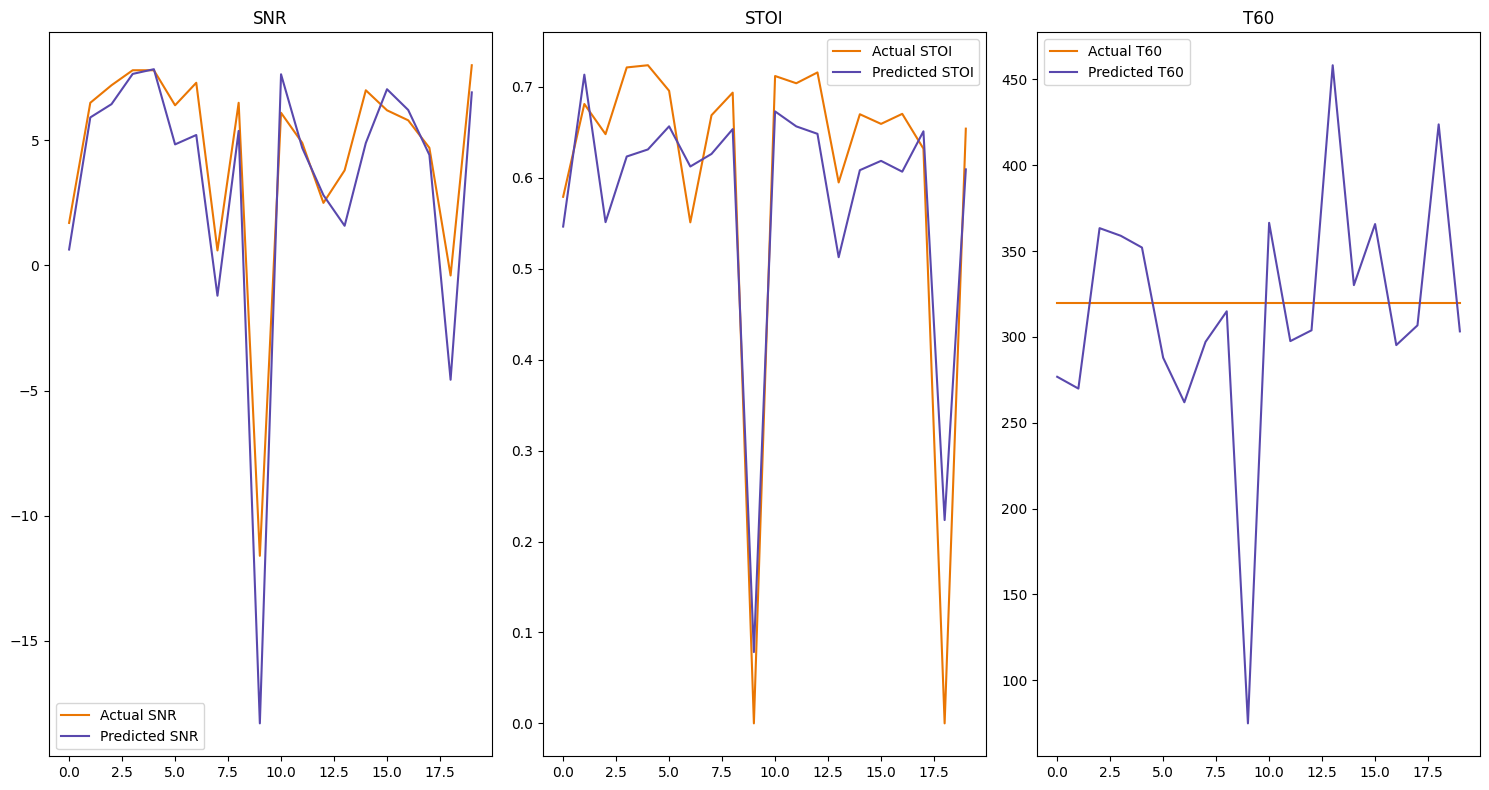

In [ ]:

language = possible_titles[3]
paint_diff(
    [results[language]["snrs_expected"][67000:67020], results[language]["stois_expected"][67000:67020],results[language]["t60_expected"][67000:67020]],
    [results[language]["snrs_predicted"][67000:67020], results[language]["stois_predicted"][67000:67020],results[language]["t60_predicted"][67000:67020]]
)

## Creation of confusion matrix

In [ ]:
transcript = {0: '(20, inf)', 1: '(10, 20]', 2: '(5, 10]', 3: '(0, 5]', 4: '(-5, 0]', 5: '(-5, -inf]'}
transcript_t60 = {0: '(0, 160)', 1: '[160, 288)', 2: '[288, 416)', 3: '[416, 544)', 4: '[544, 672)', 5: '[672, 800)'}
mse_ranges = {
    0: [[],[]],
    1: [[],[]],
    2: [[],[]],
    3: [[],[]],
    4: [[],[]],
    5: [[],[]],
    6: [[],[]]
}
mse_ranges_t60 = {
    0: [[],[]],
    1: [[],[]],
    2: [[],[]],
    3: [[],[]],
    4: [[],[]],
    5: [[],[]],
    6: [[],[]]
}

# dictionaries of counts
target_counts = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}
target_counts_t60 = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}

predicted_counts = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}
predicted_counts_t60 = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}

def beauty_print_table(table, rows):
    for i in range(table.shape[0]):
        for j, value in enumerate(table[i].tolist()):
            for v in value:
                print(f"{v:10}", end="")
            print("\n")
            if j % rows == 0 and j != 0:
                print("\n")
        print("\n")


def get_class(x):
    if x > 20:
        return 0
    elif x > 10:
        return 1
    elif x > 5:
        return 2
    elif x > 0:
        return 3
    elif x > -5:
        return 4
    else:
        return 5

def get_class_t60(x):
    if x >= 672:
        return 5
    elif x >= 544:
        return 4
    elif x >= 416:
        return 3
    elif x >= 288:
        return 2
    elif x >= 160:
        return 1
    else:
        return 0

In [ ]:
language = 'Reverberations'
table_of_resuls = torch.zeros(TEST_SETS_N, 6, 6)
table_of_resuls_t60 = torch.zeros(TEST_SETS_N, 6, 6)

In [ ]:
# snr - fulfill the matrix table_of_resuls
for j, language_set in enumerate(test_sets_titles):
    expected, predicted = results[language_set]["snrs_expected"], results[language_set]["snrs_predicted"]
    for i, expected_value in enumerate(expected):
        if abs(expected_value - predicted[i]) < 2.5:
            table_of_resuls[j][get_class(expected_value)][get_class(expected_value)] += 1
        else:
            table_of_resuls[j][get_class(predicted[i])][get_class(expected_value)] += 1

In [ ]:
# t60 - fulfill the matrix table_of_resuls_t60
for j, language_set in enumerate(test_sets_titles):
    expected, predicted = results[language_set]["t60_expected"], results[language_set]["t60_predicted"]
    for i, expected_value in enumerate(expected):
        if abs(expected_value - predicted[i]) < 60:
            table_of_resuls_t60[j][get_class_t60(expected_value)][get_class_t60(expected_value)] += 1
        else:
            table_of_resuls_t60[j][get_class_t60(predicted[i])][get_class_t60(expected_value)] += 1

In [ ]:
beauty_print_table(table_of_resuls, 6)

In [ ]:
beauty_print_table(table_of_resuls_t60, 6)

## RMSEs calculation

In [ ]:
def calculate_rmse(expected, predicted, mse_ranges, transcript, get_class):
    for i in range(len(expected)):
        class_idx = get_class(expected[i])
        error = (expected[i] - predicted[i]) ** 2
        mse_ranges[class_idx][0].append(expected[i])
        mse_ranges[class_idx][1].append(error)

    for class_idx in mse_ranges:
        mse = np.mean(mse_ranges[class_idx][1])
        rmse = np.sqrt(mse)
        print(f'Class {transcript[class_idx]} RMSE: {rmse}')

In [ ]:
for language in test_sets_titles:
    print(f'{language} dataset SNR')
    print('-------------------------------------------')
    calculate_rmse(results[language]["snrs_expected"], results[language]["snrs_predicted"], mse_ranges, transcript, get_class)
    print()
    print(f'{language} dataset t60')
    print('-------------------------------------------')
    calculate_rmse(results[language]["t60_expected"], results[language]["t60_predicted"], mse_ranges_t60, transcript_t60, get_class_t60)
    print()